# Introduction

The goal of this project is to train and evaluate a logistic regression model for the Titanic dataset. It incorporates exploratory data analysis, correlation matrices, ROC curves, and k-fold cross validation. More information about the dataset can be found here: https://www.kaggle.com/c/titanic.

This notebook was written and imported from my Kaggle, which is why it is utilizes the Kaggle environment/input paths. 

# Importing and setting up the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
print(os.listdir("../input"))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
['titanic']


In [2]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

Let's preview the data:

In [3]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("../input/titanic/train.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("../input/titanic/test.csv")

# preview train data

train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# preview test data
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print('The number of observations in our training data set is: {}'.format(train_df.shape[0]))

print('The number of observations in our testing data set is: {}'.format(test_df.shape[0]))

The number of observations in our training data set is: 891
The number of observations in our testing data set is: 418


# Data Quality & Missing Value Assessment

In [6]:
# check missing values in train data
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Missing values: Age

In [7]:
# percent of missing "Age" 
print('Percent of missing "Age" records is {0:.2f}%'.format((train_df['Age'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Age" records is 19.87%


Visualization of the "Age" Variable

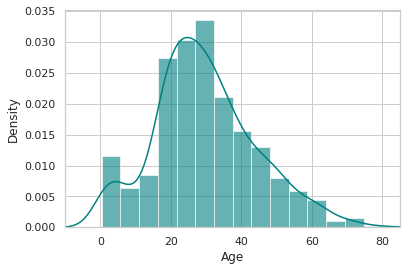

In [8]:
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Since "Age" is right skewed, using the mean to impute missing values will give us biased results by filling in ages that are older than desired. To deal with this, we'll use the median to impute the missing values.

In [9]:
# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean()))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median()))

The mean of "Age" is 29.70
The median of "Age" is 28.00


## Missing Values: Cabin

In [10]:
# percent of missing "Cabin" 
print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


Since 77.1% of the values in "Cabin" are missing, we can ignore this entire column as inputing the data would be very unreliable.

## Missing Values: Embarked

In [11]:
# percent of missing "Embarked" 
print('Percent of missing "Embarked" records is %.2f%%' %((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


We have hardly any missing data for "Embarked", so we can just impute using the mode. We can make a barplot of the Embarked data to visualize the most common value:

Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


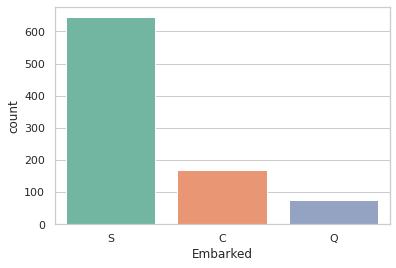

In [12]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()

The most common embarkation is "S"

## Making Final Adjustments to the Data:

We will make the following changes to the data:

1. Impute by median (28) for "Age" column.

2. Impute with mode "S" for the "Embarked" column.

3. Drop the "Cabin" column due to too many missing values.

In [13]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [14]:
# check missing values in adjusted train data
train_data.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [15]:
# preview adjusted train data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Additional Variables

Both SibSp and Parch relate to traveling with family. For simplicity's sake (and to account for possible multicollinearity), we should combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [16]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

We can also create categorical variables for Pclass and drop PassengerId, Ticket, and Name because we are not interested in making predictions based on ID, Ticket, or Name:

In [17]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


### We can apply the same data adjustments to the testing data:

Like in the training data, we will drop the Cabin column and impute age using the median (28). Since there are no missing values for embarked, we only need to impute "Fare" with its median (14.45)

In [18]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [19]:
test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


# Exploratory Data Analysis

## Age

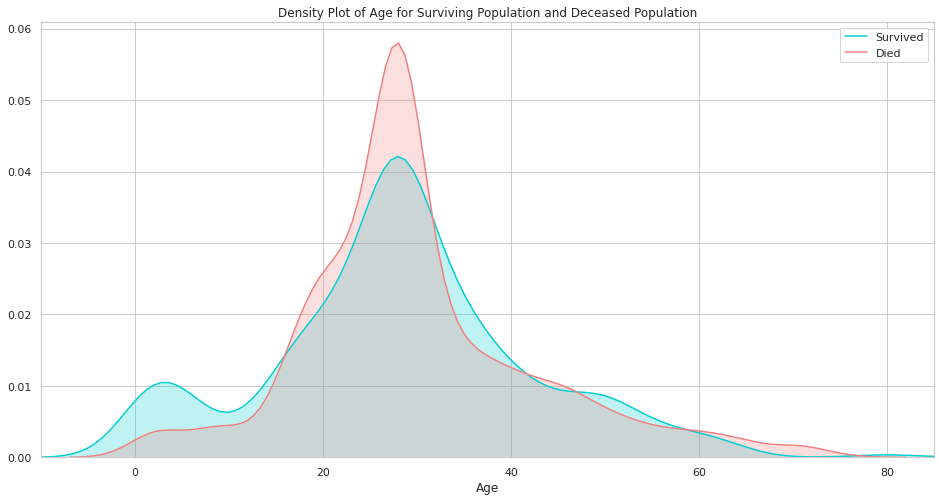

In [20]:
plt.figure(figsize=(16,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

The age distribution for survivors and deceased is very similar. One notable difference is that, of the survivors, a larger proportion were children. The passengers seem to have made an attempt to save children.

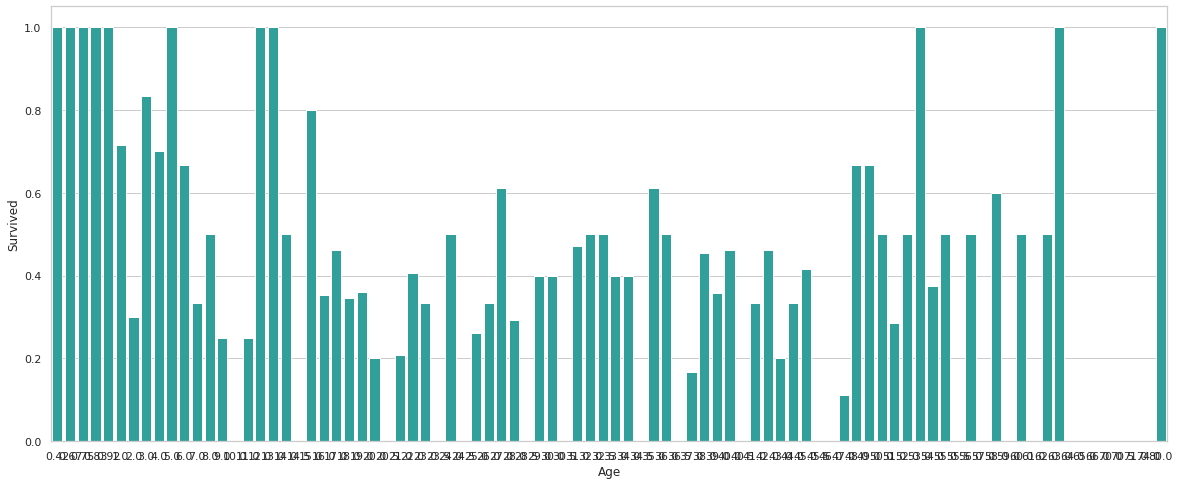

In [21]:
## Survivors per age:
plt.figure(figsize=(20,8))
avg_survival_byage = final_train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

Considering the survival rate of passengers under 16, we should include another categorical variable: "Minor"

In [22]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

## Fare

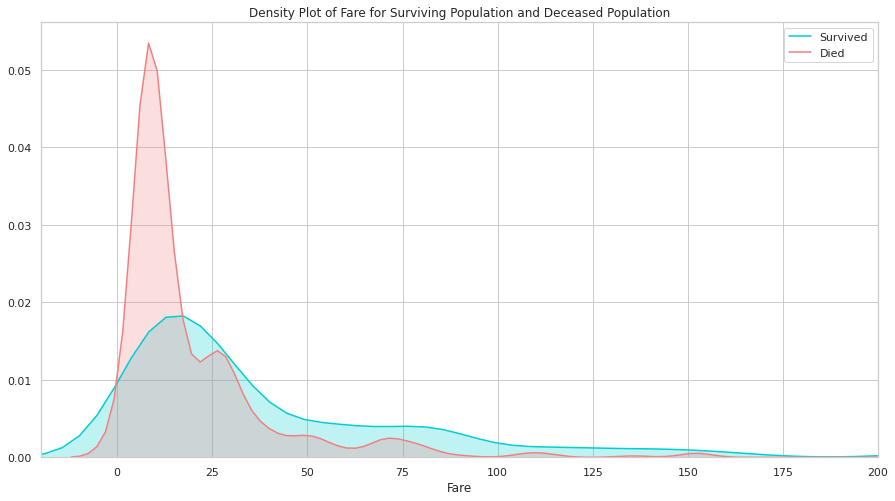

In [23]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

As the distributions are clearly different for the fares of survivors vs. deceased, it's likely that this would be a significant predictor in our final model. Passengers who paid lower fare appear to have been less likely to survive. This is probably strongly correlated with Passenger Class, which we'll look at next.

## Passenger Class

Simple barplot of the Passenger Class variable:

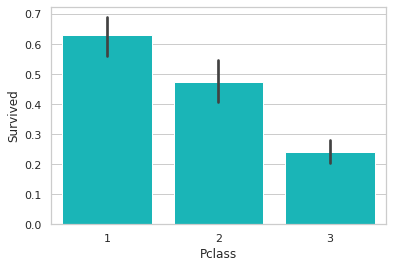

In [24]:
sns.barplot('Pclass', 'Survived', data=train_df, color="darkturquoise")
plt.show()

It appears that a higher class (first and second) resulted in more survivors.

## Embarked Port

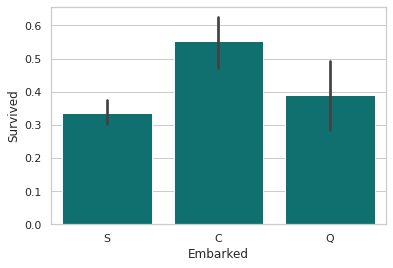

In [25]:
sns.barplot('Embarked', 'Survived', data=train_df, color="teal")
plt.show()

It seems that people who boarded in Cherbourg, France have the highest survival rate.

## Traveling Alone vs. With Family

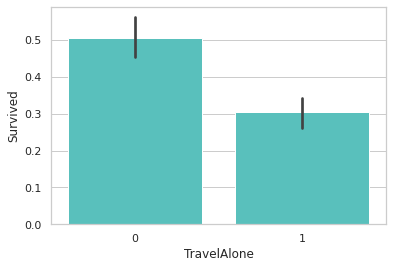

In [26]:
sns.barplot('TravelAlone', 'Survived', data=final_train, color="mediumturquoise")
plt.show()

Individuals traveling without family were more likely to die in the disaster than those with family aboard. Given the era, it's likely that individuals traveling alone were likely male.

## Gender

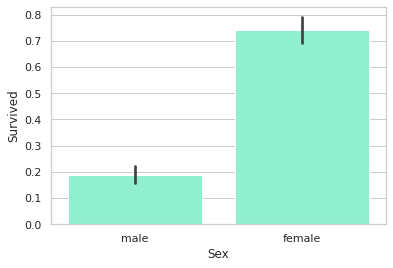

In [27]:
sns.barplot('Sex', 'Survived', data=train_df, color="aquamarine")
plt.show()

We can see that females had a higher survival rate than males.

# Logistic Regression and Results

We will be using recursive feature elimination to select the most significant variables. Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [29]:
cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


According to the RFE analysis, "Fare" is not an important feature

## Correlation Matrix:

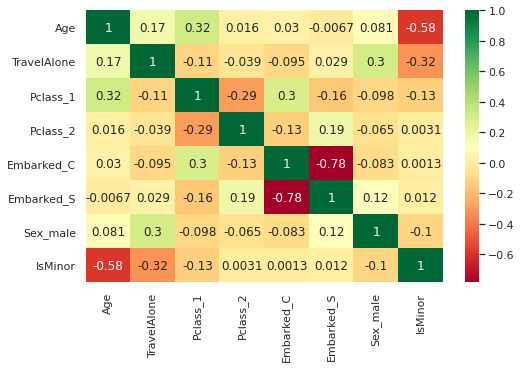

In [30]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

## Logistic Regression Code

We use a test/train split to implement logistic regression. There are a few drawbacks to doing this:

* It provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy
* Testing accuracy can change a lot depending on a which observation happen to be in the testing set

Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.504
LogisticRegression auc is 0.838


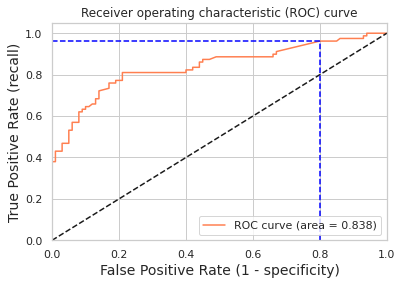

Using a threshold of  0.080 guarantees a sensitivity of 0.962 and a specificity of 0.200, i.e. a false positive rate of 80.00%.


In [35]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
X = final_train[Selected_features]
y = final_train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of  0.080 "  + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

From these results, we get an accuracy of 78.2%. The area under the ROC curve is 0.838. 

## We can get better results by using k-fold cross validation

In [36]:
# 10-fold cross-validation logistic regression
logreg = LogisticRegression()
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.795
LogisticRegression average log_loss is 0.454
LogisticRegression average auc is 0.850


Using 10 folds, we get an accuracy of 79.5%, which is slightly better than the previous result. We also get less log_loss and more area under the ROC curve. 